In [ ]:
# !pip install torchsummary

## 1.About Dataset
Overview:
This dataset comprises fractured and non-fractured X-ray images covering all anatomical body regions, including lower limb, upper limb, lumbar, hips, knees, etc. The dataset is categorized into train, test, and validation folders, each containing fractured and non-fractured radiographic images. Click this link https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data/data to access the dataset.

Dataset Contents:
This dataset contains 10,580 radiographic images (X-ray) data.

Training Data
Number of Images: 9246

Validation Data
Number of Images: 828

Test Data
Number of Images: 506

Author Credits:
Mohan Kumar
Abdelaziz Faramawy
Harsha Arya
Original Datasets:
Mohan Kumar - Bone Break Classifier Dataset
Abdelaziz Faramawy - bone_fracture
Harsha Arya - fracture
Acknowledgment:
I would like to express my gratitude to the following individuals for their contributions to the original datasets used in this combined dataset:

Mohan Kumar for the Bone Break Classifier Dataset
Abdelaziz Faramawy for the bone_fracture dataset
Harsha Arya for the fracture dataset
Links to Original Datasets:
Bone Break Classifier Dataset - https://www.kaggle.com/datasets/amohankumar/bone-break-classifier-dataset
bone_fracture Dataset - https://www.kaggle.com/datasets/abdelazizfaramawy/bone-fracture
fracture Dataset - https://kaggle.com/datasets/harshaarya/fracture
License:
The Fractured X-ray Images dataset is provided under the Open Data Commons Attribution License (ODC-By) v1.0. Users are free to use, share, and modify the dataset, provided proper attribution is given to the dataset creator.

<img src ='https://storage.googleapis.com/kaggle-datasets-images/4854718/8196063/d4f7483de7f808fc08b99c42fa7eba27/dataset-cover.jpg?t=2024-04-22-15-44-02'>

In [1]:
# Importing necessary libraries and modules for image processing and deep learning tasks

import numpy as np  # For numerical computations
import pandas as pd  # For data manipulation and analysis

from PIL import Image  # For handling image files
import matplotlib  # For creating plots
import matplotlib.pyplot as plt  # MATLAB-like interface for plotting
import matplotlib.patches as mpatches  # For creating graphical shapes

import torch  # PyTorch deep learning framework
from torch import nn  # Neural network module
from torch import optim  # Optimization module
import torch.optim as optim  # Optimization algorithms
import torch.nn.functional as F  # Functional module with activation and loss functions
from torchvision import transforms, models  # Torchvision for datasets, models, and transformations
from torch.autograd import Variable  # For automatic differentiation
from torchvision.datasets import ImageFolder  # For loading image datasets
import torch.utils.data as data  # Utilities for handling data
from torch.utils.data import DataLoader, TensorDataset  # For batch data loading and creating datasets from tensors

from torchsummary import summary  # For printing a summary of PyTorch model architecture


In [2]:
# Defining the device for tensor computations based on CUDA availability
# If CUDA (GPU) is available, use it, otherwise use CPU

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(DEVICE)


cuda


In [3]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = "https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: skjha69
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data


100%|██████████| 481M/481M [00:04<00:00, 110MB/s] 


In [5]:
import os
data_dir = '/content/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/'
os.listdir(data_dir)

['train', 'test', 'val']

In [6]:
train_dir = data_dir + 'train'
test_dir = data_dir + 'val'
val_dir = data_dir + 'test'

class_names = os.listdir(train_dir)
class_names

['fractured', 'not fractured']

## 2. Prepare DataLoader

Now we've got a dataset ready to go.

The next step is to prepare it with a [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) or `DataLoader` for short.

The `DataLoader` does what you think it might do.

It helps load data into a model.

For training and for inference.

It turns a large `Dataset` into a Python iterable of smaller chunks.

These smaller chunks are called **batches** or **mini-batches** and can be set by the `batch_size` parameter.

Why do this?

Because it's more computationally efficient.

In an ideal world you could do the forward pass and backward pass across all of your data at once.

But once you start using really large datasets, unless you've got infinite computing power, it's easier to break them up into batches.

It also gives your model more opportunities to improve.

With **mini-batches** (small portions of the data), gradient descent is performed more often per epoch (once per mini-batch rather than once per epoch).

What's a good batch size?

[32 is a good place to start](https://twitter.com/ylecun/status/989610208497360896?s=20&t=N96J_jotN--PYuJk2WcjMw) for a fair amount of problems.

But since this is a value you can set (a **hyperparameter**) you can try all different kinds of values, though generally powers of 2 are used most often (e.g. 32, 64, 128, 256, 512).

Let's create `DataLoader`'s for our training and test sets.

In [7]:
# Defining the batch size for training
BATCH_SIZE = 32

In [8]:
# Importing necessary modules
from torchvision.datasets import ImageFolder  # For loading image datasets
from torch.utils.data import DataLoader  # For batch data loading
import torchvision.transforms as transforms  # For data transformations
import os  # For interacting with the operating system
from PIL import Image  # For handling image files

# Function to identify and remove corrupted images
def identify_and_remove_corrupted_images(dataset_dir):
    corrupted_images = []  # List to store paths of corrupted images

    # Traverse through the dataset directory
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            try:
                # Attempt to open the image
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    img.load()
            except (IOError, OSError) as e:
                # If an error occurs (indicating a corrupted image), print and add to the list
                print(f"Corrupted image detected: {image_path}")
                corrupted_images.append(image_path)
                # Optionally remove the corrupted image
                # os.remove(image_path)

    return corrupted_images  # Return the list of corrupted images

# Define the paths to train and validation datasets
train_dataset_dir = train_dir
val_dataset_dir = val_dir

# Identify and remove corrupted images from train and validation datasets
corrupted_images_train = identify_and_remove_corrupted_images(train_dir)
corrupted_images_val = identify_and_remove_corrupted_images(val_dir)

# Print the number of corrupted images found in each dataset
print(f"Number of corrupted images found in train dataset: {len(corrupted_images_train)}")
print(f"Number of corrupted images found in validation dataset: {len(corrupted_images_val)}")


# Dictionary containing transformation pipelines for training and validation data
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),                           # Convert image to tensor
        transforms.CenterCrop(400),                      # Crop the center of the image to size 400x400
        transforms.RandomHorizontalFlip(),               # Randomly flip the image horizontally with a probability of 50%
        transforms.Grayscale(num_output_channels=1)]),   # Convert the image to grayscale with a single channel

    'val': transforms.Compose([
        transforms.ToTensor(),                           # Convert image to tensor
        transforms.CenterCrop(400),                      # Crop the center of the image to size 400x400
        transforms.Grayscale(num_output_channels=1)])   # Convert the image to grayscale with a single channel for validation
}

# Update the datasets to remove corrupted images
train_dataset = ImageFolder(root=train_dataset_dir,
                            transform=data_transforms['train'],
                            target_transform=None,
                            is_valid_file=None)
val_dataset = ImageFolder(root=val_dataset_dir,
                          transform=data_transforms['val'],
                          target_transform=None,
                          is_valid_file=None)

# Excluding the corrupted images from the dataset
train_dataset.samples = [(img, target) for img, target in train_dataset.samples if img not in corrupted_images_train]
val_dataset.samples = [(img, target) for img, target in val_dataset.samples if img not in corrupted_images_val]

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)


Corrupted image detected: /content/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004134.jpg
Corrupted image detected: /content/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004149.jpg
Corrupted image detected: /content/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004143.jpg
Corrupted image detected: /content/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004347.jpg
Corrupted image detected: /content/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured/IMG0004148.jpg
Corrupted image detected: /content/fracture-multi-region-x-ray-data/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_

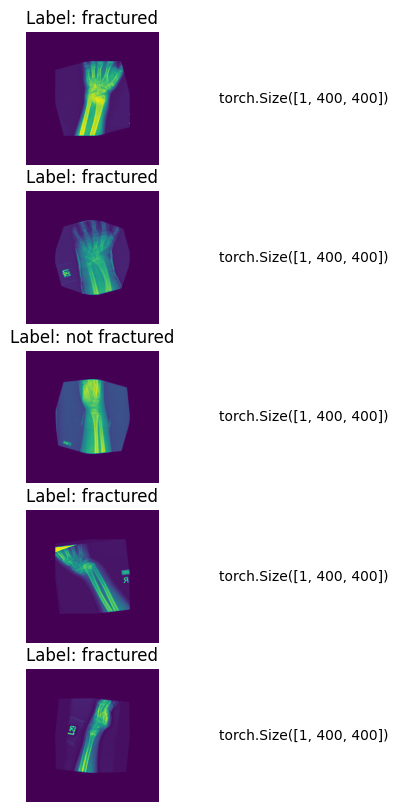

In [11]:
# Importing necessary libraries
import matplotlib.pyplot as plt  # For plotting
import numpy as np  # For numerical operations

# Function to display images with their sizes
def show_images_with_sizes(dataloader, classes, num_images=5):
    # Get a batch of data
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    # Define the figure
    fig, axs = plt.subplots(num_images, 2, figsize=(5, 10))

    # Display images and sizes
    for idx in range(num_images):
        img = images[idx].permute(1, 2, 0)  # Permute dimensions to (H, W, C) for display
        axs[idx, 0].imshow(img)
        axs[idx, 0].set_title(f"Label: {classes[labels[idx]]}")  # Display the label
        axs[idx, 0].axis('off')  # Turn off axis

        # Display tensor size
        axs[idx, 1].text(0.5, 0.5, str(images[idx].size()), horizontalalignment='center', verticalalignment='center')
        axs[idx, 1].axis('off')  # Turn off axis

    plt.show()  # Show the plot

# Call the function to display images with their sizes
show_images_with_sizes(train_loader, class_names, num_images=5)

<div style=" padding:20px; text-align:center">
    <h1>🔍 3.AlexNet: 🔍</h1>
</div>
<div style="; padding:20px;">
AlexNet is a deep convolutional neural network (CNN) architecture designed for image classification tasks. It gained significant attention after winning the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012.

## 🛠️ How it Works

1. **Convolutional Layers**: AlexNet consists of several layers that process input images in a hierarchical manner. The initial layers detect simple patterns like edges and textures.
  
2. **Pooling Layers**: These layers reduce the spatial dimensions of the feature maps generated by the convolutional layers, helping the network focus on the most important features.
  
3. **ReLU Activation**: Rectified Linear Units (ReLU) are used as activation functions in AlexNet. They introduce non-linearity, allowing the network to learn more complex patterns.
  
4. **Fully Connected Layers**: Towards the end of the network, there are fully connected layers that combine the features learned from previous layers to make predictions. These layers perform classification based on the extracted features.

## 🌟 Key Features

- **Deep Architecture**: AlexNet consists of eight layers, including five convolutional layers followed by three fully connected layers. This depth allows it to learn intricate features from images.
  
- **Dropout**: AlexNet uses dropout regularization during training to prevent overfitting. Dropout randomly drops neurons during training, forcing the network to learn redundant representations and thus improving generalization.
  
- **Data Augmentation**: The network is trained with augmented data, including random crops, flips, and color distortions. This technique helps the model generalize better to unseen data.

## 🎉 Conclusion

AlexNet revolutionized the field of computer vision by demonstrating the effectiveness of deep learning models for image classification tasks. Its success paved the way for more advanced architectures and sparked a surge of interest in deep learning research.

</div>


In [12]:
# Define the AlexNet convolutional neural network class
class AlexNet(nn.Module):
    def __init__(self, n_classes = 2):
        super(AlexNet, self).__init__()

        # Define the layers of the network

        # 1st conv layer
        self.Conv_1 = nn.Sequential(
          nn.Conv2d(in_channels = 1, out_channels = 96, kernel_size = 11, stride = 4, padding = 0),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
          nn.BatchNorm2d(96))

        # 2nd conv layer
        self.Conv_2 = nn.Sequential(
          nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, stride = 1, padding = 2),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2),
          nn.BatchNorm2d(256))

        # 3rd conv layer
        self.Conv_3 = nn.Sequential(
          nn.Conv2d(in_channels = 256, out_channels = 384, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU())

        # 4th conv layer
        self.Conv_4 = nn.Sequential(
          nn.Conv2d(in_channels = 384, out_channels = 384, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU())

        # 5th conv layer
        self.Conv_5 = nn.Sequential(
          nn.Conv2d(in_channels = 384, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size = 3, stride = 2))

        # 1st fully connected layer
        self.FC1 = nn.Sequential(
          nn.Flatten(),
          nn.Dropout(0.5),
          nn.Linear(256*11*11, 4096),
          nn.ReLU())

        # 2nd fully connected layer
        self.FC2 = nn.Sequential(
          nn.Dropout(0.5),
          nn.Linear(4096, 4096),
          nn.ReLU())

        # 3rd fully connected layer --> output layer
        self.FC3 = nn.Sequential(
          nn.Linear(4096, n_classes))

    def forward(self, x):   # AlexNet forward propagation function
        # Propagate input through the layers of the network
        x = self.Conv_1(x)
        x = self.Conv_2(x)
        x = self.Conv_3(x)
        x = self.Conv_4(x)
        x = self.Conv_5(x)
        x = self.FC1(x)
        x = self.FC2(x)
        x = self.FC3(x)

        return F.log_softmax(x)

# Instantiate the AlexNet model and move it to the appropriate device (GPU if available, otherwise CPU)
model = AlexNet().to(DEVICE)

# Print the architecture of the model
model

AlexNet(
  (Conv_1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv_2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv_3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (Conv_4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (Conv_5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilati

In [13]:
# Print the summary of the model
summary(model, (1, 400, 400))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 98, 98]          11,712
              ReLU-2           [-1, 96, 98, 98]               0
         MaxPool2d-3           [-1, 96, 48, 48]               0
       BatchNorm2d-4           [-1, 96, 48, 48]             192
            Conv2d-5          [-1, 256, 48, 48]         614,656
              ReLU-6          [-1, 256, 48, 48]               0
         MaxPool2d-7          [-1, 256, 23, 23]               0
       BatchNorm2d-8          [-1, 256, 23, 23]             512
            Conv2d-9          [-1, 384, 23, 23]         885,120
             ReLU-10          [-1, 384, 23, 23]               0
           Conv2d-11          [-1, 384, 23, 23]       1,327,488
             ReLU-12          [-1, 384, 23, 23]               0
           Conv2d-13          [-1, 256, 23, 23]         884,992
             ReLU-14          [-1, 256,

<ipython-input-12-1dae4216e686>:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


### 3.1 Setup loss, optimizer and evaluation metrics


> **Note:** Rather than importing and using our own accuracy function or evaluation metric(s), you could import various evaluation metrics from the [TorchMetrics package](https://torchmetrics.readthedocs.io/en/latest/).

In [14]:
# Define the loss function (criterion)
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### 4 Functionizing training and test loops

So far we've been writing train and test loops over and over.

Let's write them again but this time we'll put them in functions so they can be called again and again.

And because we're using device-agnostic code now, we'll be sure to call `.to(device)` on our feature (`X`) and target (`y`) tensors.

For the training loop we'll create a function called `train_step()` which takes in a model, a `DataLoader` a loss function and an optimizer.

The testing loop will be similar but it'll be called `test_step()` and it'll take in a model, a `DataLoader`, a loss function and an evaluation function.

> **Note:** Since these are functions, you can customize them in any way you like. What we're making here can be considered barebones training and testing functions for our specific classification use case.

In [15]:
def train(model, train_loader, optimizer):
    # Set the model to training mode
    model.train()

    # Iterate through batches of data in the train_loader
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data and target tensors to the appropriate device (GPU if available, otherwise CPU)
        data, target = data.to(DEVICE), target.to(DEVICE)

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # Calculate the batch loss
        loss =  criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

In [16]:
def evaluate(model, test_loader):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables for test loss and correct predictions
    test_loss = 0
    correct = 0

    # Turn off gradients during evaluation
    with torch.no_grad():
        # Iterate through batches of data in the test_loader
        for data, target in test_loader:
            # Move data and target tensors to the appropriate device (GPU if available, otherwise CPU)
            data, target = data.to(DEVICE), target.to(DEVICE)

            # Forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            # Compute the total test loss
            test_loss += criterion(output, target).item()

            # Get the index of the highest probability prediction
            pred = output.max(1, keepdim=True)[1]

            # Count the number of correct predictions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Calculate the average test loss
    test_loss /= len(test_loader.dataset)

    # Calculate the test accuracy
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy


### 5 Creating a training loop and training a model on batches of data

Beautiful!

Looks like we've got all of the pieces of the puzzle ready to go, a timer, a loss function, an optimizer, a model and most importantly, some data.

Let's now create a training loop and a testing loop to train and evaluate our model.

We'll be using the same steps as the previous notebook(s), though since our data is now in batch form, we'll add another loop to loop through our data batches.

Our data batches are contained within our `DataLoader`s, `train_dataloader` and `test_dataloader` for the training and test data splits respectively.

A batch is `BATCH_SIZE` samples of `X` (features) and `y` (labels), since we're using `BATCH_SIZE=32`, our batches have 32 samples of images and targets.

And since we're computing on batches of data, our loss and evaluation metrics will be calculated **per batch** rather than across the whole dataset.

This means we'll have to divide our loss and accuracy values by the number of batches in each dataset's respective dataloader.

Let's step through it:
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all (for fun).

A fair few steps but...

...if in doubt, code it out.

In [17]:
import time  # Importing time module for time tracking
import copy  # Importing copy module for deep copying model weights

def train_model(model, train_loader, val_loader, optimizer, num_epochs=30):
    # Lists to store training and validation accuracies and losses for each epoch
    acc_t = []  # Training accuracy
    acc_v = []  # Validation accuracy
    loss_t = []  # Training loss
    loss_v = []  # Validation loss

    best_acc = 0.0  # Best validation accuracy initialized to 0.0
    best_model_wts = copy.deepcopy(model.state_dict())  # Deep copy of model weights as the best model

    # Loop through each epoch
    for epoch in range(1, num_epochs + 1):
        since = time.time()  # Record the start time of the epoch

        # Train the model for one epoch
        train(model, train_loader, optimizer)

        # Evaluate the model on the training and validation sets to get loss and accuracy
        train_loss, train_acc = evaluate(model, train_loader)
        val_loss, val_acc = evaluate(model, val_loader)

        # Update the best validation accuracy and best model weights if the current validation accuracy is higher
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Append current epoch's accuracy and loss values to the lists
        acc_t.append(train_acc)
        acc_v.append(val_acc)
        loss_t.append(train_loss)
        loss_v.append(val_loss)

        time_elapsed = time.time() - since  # Calculate time elapsed for the epoch

        # Print epoch statistics
        print('-------------- EPOCH {} ----------------'.format(epoch))
        print('Train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))
        print('Val Loss: {:.4f}, Accuracy: {:.2f}%'.format(val_loss, val_acc))
        print('Time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print()

    # Plot accuracy graph
    plt.plot(range(len(acc_t)), acc_t, 'b', range(len(acc_v)), acc_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Accuracy')
    red_patch = mpatches.Patch(color='red', label='Validation Accuracy')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

    # Plot loss graph
    plt.plot(range(len(loss_t)), loss_t, 'b', range(len(loss_v)), loss_v, 'r')
    blue_patch = mpatches.Patch(color='blue', label='Train Loss')
    red_patch = mpatches.Patch(color='red', label='Validation Loss')
    plt.legend(handles=[red_patch, blue_patch])
    plt.show()

    # Load the best model weights
    model.load_state_dict(best_model_wts)

    # Return the model with the best weights
    return model

<ipython-input-12-1dae4216e686>:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


-------------- EPOCH 1 ----------------
Train Loss: 0.0104, Accuracy: 86.79%
Val Loss: 0.0147, Accuracy: 78.00%
Time: 2m 7s

-------------- EPOCH 2 ----------------
Train Loss: 0.0029, Accuracy: 96.24%
Val Loss: 0.0109, Accuracy: 84.60%
Time: 2m 4s

-------------- EPOCH 3 ----------------
Train Loss: 0.0020, Accuracy: 97.26%
Val Loss: 0.0063, Accuracy: 86.20%
Time: 2m 3s

-------------- EPOCH 4 ----------------
Train Loss: 0.0021, Accuracy: 97.03%
Val Loss: 0.0093, Accuracy: 87.20%
Time: 2m 12s

-------------- EPOCH 5 ----------------
Train Loss: 0.0011, Accuracy: 98.34%
Val Loss: 0.0050, Accuracy: 89.00%
Time: 2m 10s

-------------- EPOCH 6 ----------------
Train Loss: 0.0008, Accuracy: 98.80%
Val Loss: 0.0045, Accuracy: 89.80%
Time: 2m 2s

-------------- EPOCH 7 ----------------
Train Loss: 0.0009, Accuracy: 98.76%
Val Loss: 0.0067, Accuracy: 89.20%
Time: 2m 7s

-------------- EPOCH 8 ----------------
Train Loss: 0.0007, Accuracy: 98.95%
Val Loss: 0.0042, Accuracy: 92.80%
Time: 2m 7s

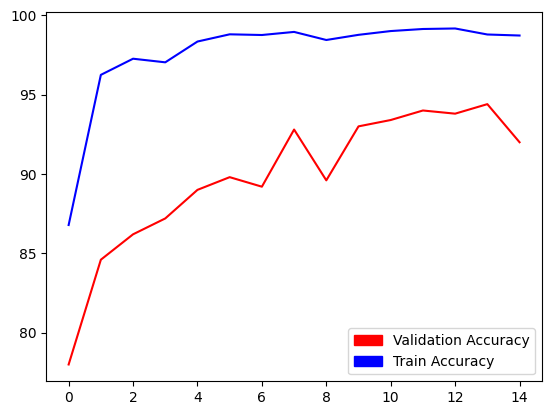

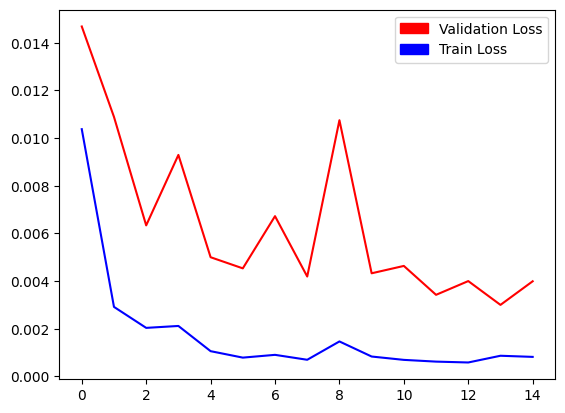

In [18]:
# Defining the number of epochs for training
EPOCH = 15

# Calling the train_model function to train the model
# The function takes the current model, training data loader (train_loader),
# validation data loader (val_loader), optimizer, and number of epochs as inputs
model = train_model(model, train_loader, val_loader, optimizer, EPOCH)
# The trained model with the best validation accuracy is returned and assigned to the variable 'model'

<div style="background-color:#FFE4B5; padding:20px; text-align:center">
    <h2>Evaluate Model</h2>
</div>


In [19]:
# Set the model to evaluation mode
model.eval()

# Evaluate the model on the training data to get the training accuracy
# The evaluate function returns both loss and accuracy, but we're only interested in accuracy here,
# hence using '_' to ignore the loss value
_, train_acc = evaluate(model, train_loader)

# Evaluate the model on the validation data to get the validation accuracy
_, val_acc = evaluate(model, val_loader)

# Print the saved model's training accuracy
print('Train Accuracy: {:.4f}'.format(train_acc))

# Print the saved model's validation accuracy
print('Validation Accuracy: {:.4f}'.format(val_acc))


<ipython-input-12-1dae4216e686>:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Accuracy: 98.9069
Validation Accuracy: 94.4000


## 6. Save and load best performing model

Let's finish this section off by saving and loading in our best performing model.

Recall from [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/#5-saving-and-loading-a-pytorch-model) we can save and load a PyTorch model using a combination of:
* `torch.save` - a function to save a whole PyTorch model or a model's `state_dict()`.
* `torch.load` - a function to load in a saved PyTorch object.
* `torch.nn.Module.load_state_dict()` - a function to load a saved `state_dict()` into an existing model instance.

You can see more of these three in the [PyTorch saving and loading models documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

For now, let's save our `model_2`'s `state_dict()` then load it back in and evaluate it to make sure the save and load went correctly.

In [22]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("pytorch_saved_model")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "BoneFracture.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: pytorch_saved_model/BoneFracture.pth


In [25]:

loaded_model = AlexNet(2)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model = loaded_model.to(DEVICE)

In [27]:
# Set the model to evaluation mode
loaded_model.eval()

# Evaluate the model on the training data to get the training accuracy
# The evaluate function returns both loss and accuracy, but we're only interested in accuracy here,
# hence using '_' to ignore the loss value
_, train_acc = evaluate(loaded_model, train_loader)

# Evaluate the model on the validation data to get the validation accuracy
_, val_acc = evaluate(loaded_model, val_loader)

# Print the saved model's training accuracy
print('Train Accuracy: {:.4f}'.format(train_acc))

# Print the saved model's validation accuracy
print('Validation Accuracy: {:.4f}'.format(val_acc))

<ipython-input-12-1dae4216e686>:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Accuracy: 98.9177
Validation Accuracy: 94.4000


In [20]:
# Importing the necessary function from scikit-learn library
from sklearn.metrics import classification_report

# Function for making predictions and generating classification report
def prediction(model, data_loader):
    # Set the model to evaluation mode
    model.eval()

    # Initialize empty tensors to store predictions and labels
    predlist = torch.zeros(0, dtype=torch.long, device='cpu')
    lbllist = torch.zeros(0, dtype=torch.long, device='cpu')

    # Turn off gradient calculation for inference
    with torch.no_grad():
        # Iterate over the batches in the data loader
        for i, (data, label) in enumerate(data_loader):
            # Move data and label tensors to the appropriate device (GPU if available, otherwise CPU)
            data = data.to(DEVICE)
            label = label.to(DEVICE)

            # Forward pass to get model predictions
            outputs = model(data)

            # Get the predicted class labels
            _, preds = torch.max(outputs, 1)

            # Append batch predictions and labels to the predlist and lbllist tensors
            predlist = torch.cat([predlist, preds.view(-1).cpu()])
            lbllist = torch.cat([lbllist, label.view(-1).cpu()])

    # Generate and print the classification report using scikit-learn's classification_report function
    print(classification_report(lbllist.numpy(), predlist.numpy()))

    # Return None as there is no specific output returned by this function
    return


In [28]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = DEVICE):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

import random
random.seed(69)
test_samples = []
test_labels = []
for sample, label in random.sample(list(val_dataset), k=16):
    test_samples.append(sample)
    test_labels.append(label)

pred_probs= make_predictions(model=loaded_model,
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)
pred_classes

test_labels, pred_classes

<ipython-input-12-1dae4216e686>:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1],
 tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]))

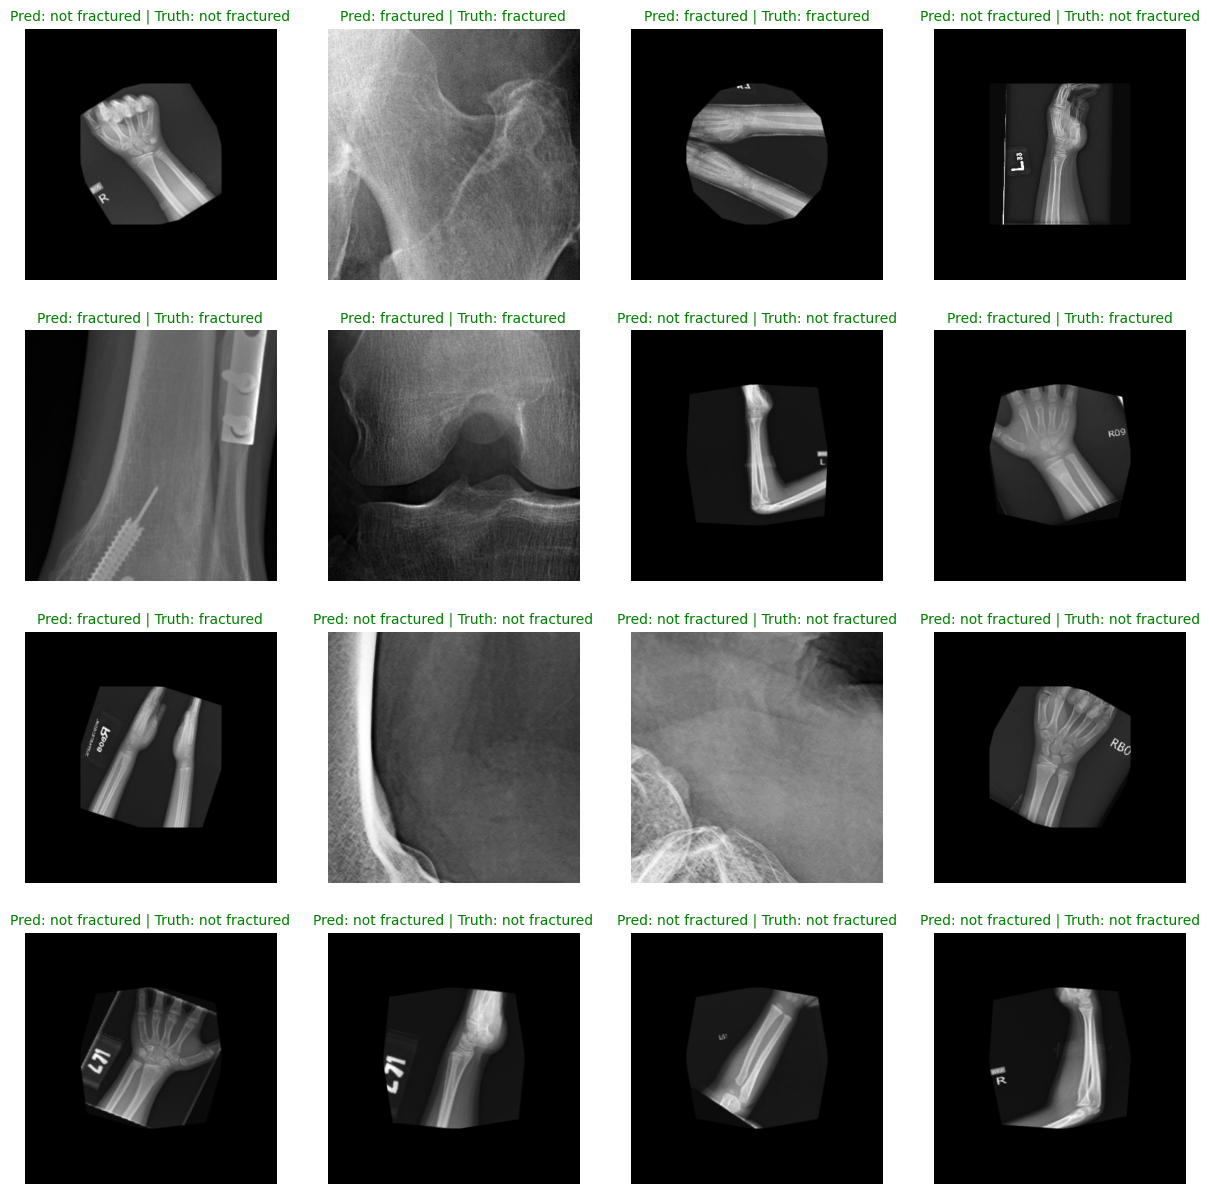

In [30]:
# Plot predictions
plt.figure(figsize=(15, 15))
nrows = 4
ncols = 4
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## 7. Making a confusion matrix for further prediction evaluation

There are many [different evaluation metrics](https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics) we can use for classification problems.

One of the most visual is a [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/).

A confusion matrix shows you where your classification model got confused between predicitons and true labels.

To make a confusion matrix, we'll go through three steps:
1. Make predictions with our trained model, `model_2` (a confusion matrix compares predictions to true labels).
2. Make a confusion matrix using [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html?highlight=confusion#confusionmatrix).
3. Plot the confusion matrix using [`mlxtend.plotting.plot_confusion_matrix()`](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/).

Let's start by making predictions with our trained model.

In [40]:
def get_preds(model , dataloader):
    from tqdm.auto import tqdm
    y_preds = []
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions"):

            X, y = X.to(DEVICE), y.to(DEVICE)

            y_logit = model(X)

            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

            y_preds.append(y_pred.cpu())

    y_pred_tensor = torch.cat(y_preds)
    return y_pred_tensor
val_preds = get_preds(loaded_model , val_loader)
val_preds[:10]

Making predictions:   0%|          | 0/16 [00:00<?, ?it/s]

<ipython-input-12-1dae4216e686>:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([0, 1, 1, 1, 0, 0, 0, 0, 0, 0])

In [34]:
!pip install torchmetrics --quiet

## Classification report

In [21]:
# Call the prediction function for making predictions and generating classification report
prediction(model, val_loader)

<ipython-input-12-1dae4216e686>:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


              precision    recall  f1-score   support

           0       0.89      1.00      0.94       238
           1       1.00      0.89      0.94       262

    accuracy                           0.94       500
   macro avg       0.95      0.95      0.94       500
weighted avg       0.95      0.94      0.94       500

